<center>

# Trabajo Práctico Final

## Procesamiento de imágenes biomédicas

### Primer Cuatrimestre 2024

</center>

**Docentes:**

- Roberto Sebastián Tomás
- Aylin Agatha Vazquez Chenlo
- Francisco Tassara

**Alumnxs:**

- Bajle, Ivo - 62175
- Grau, Gonzalo - 62259
- Pereira, Camila Noemi - 61574

### Objetivo del trabajo

El objetivo del presente trabajo es desarrollar un algoritmo para investigar la translucencia nucal en la etapa gestacional a partir de imágenes de ultrasonido. Este proyecto se llevará a cabo utilizando los conocimientos adquiridos en las clases teóricas de la materia. Al crear un algoritmo capaz de medir la translucencia nucal con la mayor precisión posible, se pretende obtener una comprensión más profunda y proporcionar herramientas precisas para el diagnóstico temprano de anomalías cromosómicas y otros problemas fetales. Los resultados de este estudio podrían contribuir significativamente al campo de la obstetricia. 

### Estado del arte 

En 1985, se descubrió la conexión entre el incremento del pliegue nucal en fetos del segundo trimestre y las alteraciones cromosómicas. En el primer trimestre, se observó una asociación similar y se introdujo el término “translucencia nucal” (TN) para describir la región sonoluscente en la parte posterior de la nuca fetal. Estudios realizados en gestantes de alto riesgo confirmaron esta relación. [4]

Inicialmente, la TN se evaluaba utilizando un punto de corte fijo. Sin embargo, se observó que la TN aumentaba con la edad gestacional, lo que llevó a la adopción de una curva de valores de referencia en función de la longitud cefalocaudal (LCC). Posteriormente, se desarrolló un modelo matemático que combinaba el riesgo asociado a la TN con la edad materna y los marcadores bioquímicos, dando lugar al método de cribado combinado. Este método resultó ser más eficaz y coste-eficiente que el cribado bioquímico en el segundo trimestre. 

En la práctica clínica rutinaria, se ha comprobado que es posible obtener resultados similares, siempre y cuando se respeten estrictamente las técnicas de medición y los controles de calidad.

Entre la semana 11 y 14 de gestación, todos los fetos desarrollan una colección de líquido en la nuca, visible ecográficamente. El incremento de TN se asocia con edema nucal que puede ser producto de diversas patologías. Las teorías propuestas incluyen fallo cardiaco, congestión venosa, alteraciones en la matriz extracelular y desarrollo anormal del sistema linfático. Después de la semana 14, el sistema linfático se desarrolla lo suficiente para drenar cualquier colección de líquido, por lo que la desaparición del incremento TN no debe interpretarse como un hallazgo tranquilizador.

Para medir la TN, se debe seguir la técnica estándar de la Fetal Medicine Foundation (FMF):
- Realizar la medición cuando la LCC del feto esté entre 45 y 84 mm (semanas 11 a 13+6 días).
- Usar un ecógrafo de alta resolución, preferentemente por vía abdominal. Cuando no sea factible se puede optar por la vía transvaginal.
- La medición debe realizarse en la visión sagital del embrión, con el feto en posición natural y la cabeza alineada con la columna.
- La imagen embrionaria debe estar ampliada de manera que incluya solamente la cabeza fetal y la parte superior del tórax.
- La medición debe realizarse en la zona más ancha de la TN y deben tomarse tres mediciones, quedando como válida la mayor de las tres.
- Para evitar confusiones, se debe diferenciar la línea generada por la membrana amniótica de la correspondiente a la piel fetal y evitar que el cordón umbilical se posicione  alrededor del cuello fetal.



### Base de datos

Para realizar nuestro trabajo, adquirimos las imágenes necesarias disponibles en [1]. Esta base de datos contiene 1528 imágenes de ultrasonido en vista sagital 2D, recolectadas del Shenzhen People's Hospital de 1519 gestantes. Además, incluye 156 imágenes adicionales provenientes del hospital filial de Longhua del Shenzhen People's Hospital.  

### Materiales y métodos

Para el desarrollo de este trabajo, se hará uso de los siguientes módulos de código abierto:
- numpy
- matplotlib
- openCV
- SimpleITK
- scipy

Además, se desarrolló un módulo propio de procesamiento de imágenes, disponible en el archivo _my\_image\_processor.py_. Utilizando estas herramientas, se aplicaron las siguientes técnicas:
- Ecualización del histograma
- Segmentación por método de etiquetado
- Segmentación por region growing
- Binarización por umbralizado
- Filtrado convolucional mediante kernels lineales
- Filtrado no lineal por filtro de mediana
- Regresión lineal por cuadrados mínimos

Para cado uno de los casos presentado a continuación, el procesamiento aplicado consiste de los siguientes pasos:
1. Lectura de la imagen desde un archivo .png
2. Selección inicial de uno o dos puntos internos al área de la translucencia nucal
3. Segmentado del área de la TN, a partir del punto interno previamente especificado
4. Detección del borde de la TN
5. Ajuste mediante cuadrados mínimos de una elipse al perímetro de la TN
6. Medición de la TN definida como el diámetro menor de dicha elipse

### Desarrollo

Se comienza enunciando todas las librerías con las que se trabajaron en el desarrollo de algoritmo. Antes de explicar el funcionamiento general de lo que se desarrollo, debemos recordar el modulo de my_img_processor porque importa la clase My_Image que posee funciones que vamos a necesitar.

In [23]:
from typing import Tuple, Self, List
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from my_img_processor import My_Image
import matplotlib as mpl
import cv2
from scipy.ndimage import label

In [ ]:
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')

Se visualiza la imagen de ultrasonido con la que se va a trabajar. Por lo tanto, para todo lo enunciado a posterior, elegimos la imagen 1426.png.

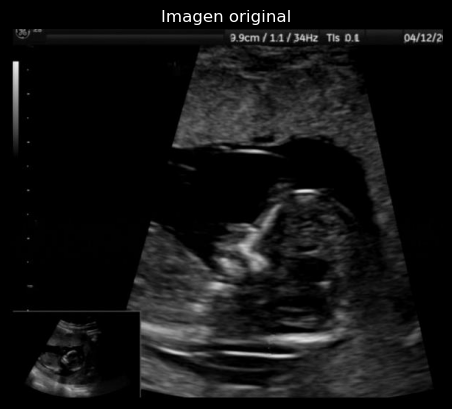

In [24]:
img_path = r'Dataset for Fetus Framework\Dataset for Fetus Framework\External Test Set\Standard\1426.png'
raw_img = My_Image(img_path)

fig_raw, ax_raw = plt.subplots()
ax_raw.imshow(raw_img, vmin=0, vmax=255, cmap='gray')
ax_raw.set_title('Imagen original')
plt.axis('off')
plt.show()

Se tiene un gráfico interactivo, que detecta los puntos que seleccionas dentro de la imagen y los guarda en variables globales (x,y). Estos puntos se van ubicar en el área que se va a utilizar para medir la TN. 

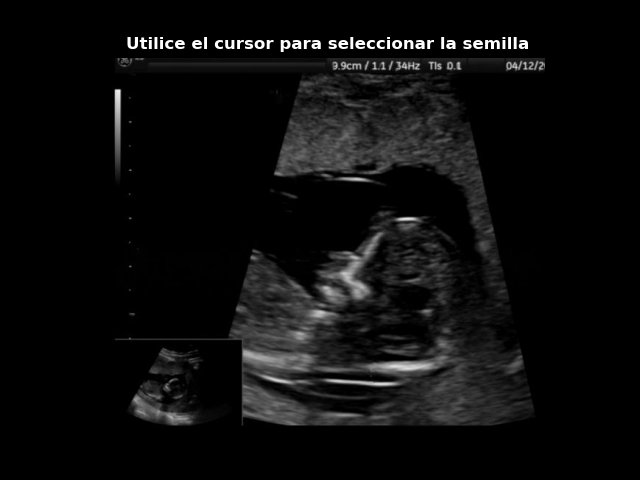

In [28]:
%matplotlib widget
x, y = 315, 432
def interactive_plot(img):
   plt.ion()
   fig, ax = plt.subplots()
   fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)
   ax.set_title('Utilice el cursor para seleccionar la semilla', fontweight='bold')
   def onclick(event):
      global x
      global y
      x = int(np.ceil(event.xdata))
      y = int(np.ceil(event.ydata))
      print(f"{x=}, {y=}")
      ax.plot(x, y, marker='x', color='yellow')
      ax.figure.canvas.draw()
      fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)

   ax.imshow(img, vmin=0, vmax=255, cmap='gray')
   plt.axis(False)
   fig.canvas.mpl_connect('button_press_event', onclick)
   plt.show()

interactive_plot(raw_img)

Una vez que se encuentran seleccionados los puntos, se cierra el gráfico interactivo.

In [ ]:
plt.close()
%matplotlib inline

No such comm: 6a931d6caaf94d87a8b026e448bf2d4f


Para poder obtener el área para medir la TN, se desarrollaron tres tipos de segmentación: Segmentación por contraste, etiquetado y region growing.

##### 1) Segmentación por contraste

Se binariza la imagen utilizando el punto medio de histograma ecualizado. Para realizar esto, utilizamos la función de equalize_hist() y get_hist() que estan dentro de la clase My_Image. 

_Observación: la siguiente celda se incluye solo a modo ilustrativo, y el código allí presente se encuentra dentro del módulo my\_image\_processor_

In [30]:
def equalize_hist(self) -> Self:
        """
        Applies the histograme equalizing algorithm
        """
        # define constants
        N, M = self.shape
        dtype_data = np.iinfo(self.dtype)
        L = dtype_data.max - dtype_data.min + 1
        k_min = self.min()

        # get original histogram and integrate it
        bins, hist = self.get_hist(plot=False)
        hist_cdf = np.cumsum(hist)
        cdf_min = hist_cdf[k_min]

        # define the transformation, and apply it
        hist_eq = np.round(((hist_cdf - cdf_min)/(M*N - cdf_min))*(L - 1))
        return My_Image(hist_eq[self])


def get_hist(self,
             vmin: int=0,
             vmax: int=255,
             N_bins: int=0,
             plot: bool=True) -> tuple[np.ndarray, np.ndarray]:
        """
        vmin: minimum intensity
        vmax: maximum intensity
        N_bins: amount of values to calculate their frequency

        return: bins, hist
        """
        if N_bins == 0:
            N_bins = vmax - vmin + 1

        bins = np.linspace(vmin, vmax, N_bins, dtype='uint8')
        img_ravel = self.ravel()
        hist = np.zeros(N_bins)

        for px in img_ravel:
            hist[bins == px] += 1

        if plot:
            fig, ax = plt.subplots()
            ax.bar(bins, hist, width=1)
            plt.show()

        return bins, hist  

Con esta función, se aplicar una transformación tal a la imagen original que permite obtener como salida una nueva imagen con el contraste mejorado.

In [31]:
eq_img = raw_img.equalize_hist()

In [32]:
bin_img = np.zeros_like(raw_img)
THRES = 255//2
for i in range(bin_img.shape[0]):
    for j in range(bin_img.shape[1]):
        if eq_img[i, j] > THRES:
            bin_img[i, j] = 255

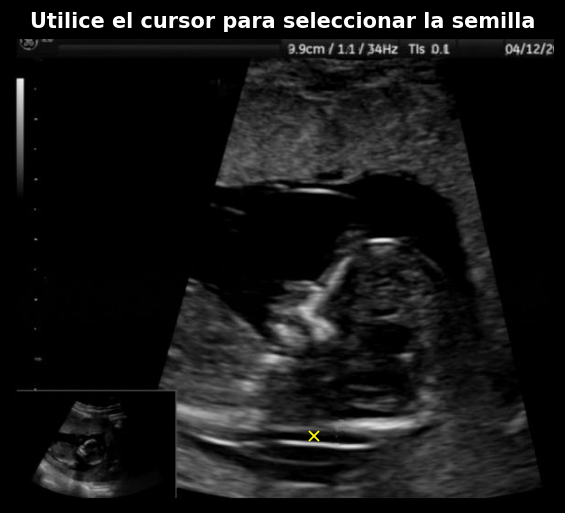

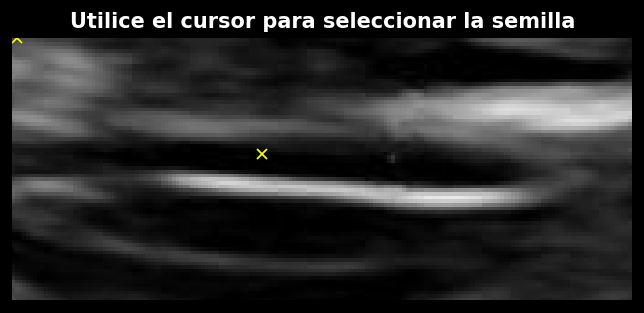

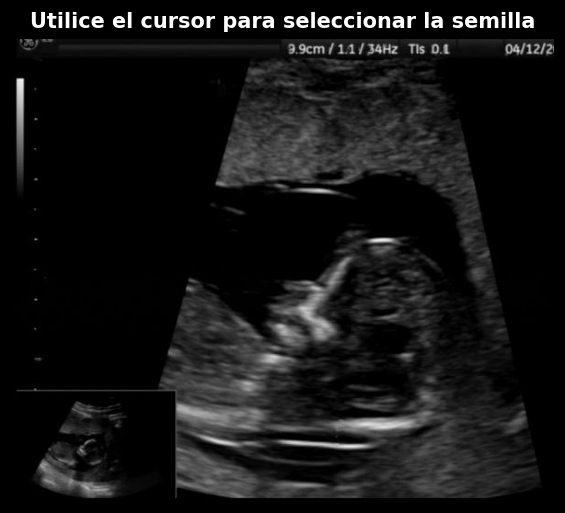

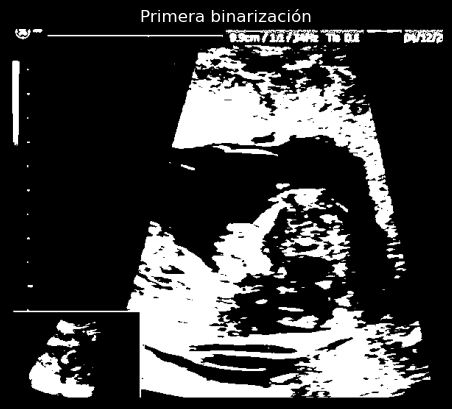

In [33]:
fig_bin, ax_bin = plt.subplots()
ax_bin.imshow(bin_img, vmin=0, vmax=255, cmap='gray')
ax_bin.set_title('Primera binarización')
plt.axis(False)
plt.show()

Al observar la imagen, se puede presenciar ruido de tipo sal y pimienta en ella. Es por eso, que se busca eliminar este ruido de la imagen. Para realizar utilizamos la función median_filter() de la clase My_Image.

In [34]:
def median_filter(self, window_size: float, pad_mode: str='zero') -> Self:
    """
    window_size: dimension of the window to convolve
    pad_mode: chosen padding method, either 'zero' or 'expand'

    return: the filtered image after applying the filter
    """
    N, M = self.shape
    pad_num = window_size//2

    if pad_mode == 'zero':
        padded_img = self.zero_pad(window_size)
    elif pad_mode =='expand':
        padded_img = self.expand_pad(window_size)
    else:
        raise ValueError(f"'{pad_mode}' is not a valid padding mode," +
                        "should  be either 'zero' or 'expand'")

    filtered_img = np.zeros_like(self)
    for i in range(pad_num, N):
        for j in range(pad_num, M):
            window = padded_img[i - pad_num : i + pad_num + 1,
                                j - pad_num : j + pad_num + 1]
            filtered_img[i, j] = np.median(window)

    return My_Image(filtered_img)

In [35]:
sp_img = bin_img.median_filter(5)

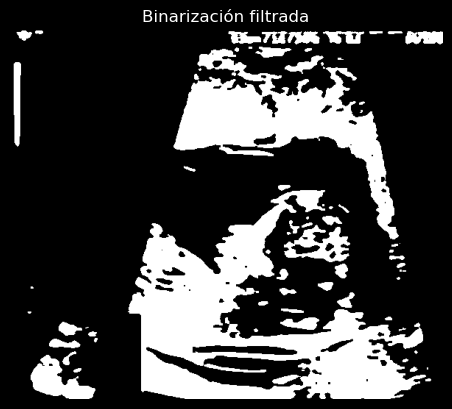

In [36]:
fig_sp, ax_sp = plt.subplots()
ax_sp.imshow(sp_img, vmin=0, vmax=255, cmap='gray')
ax_sp.set_title('Binarización filtrada')
plt.axis(False)
plt.show()

Con la imagen que se obtenien luego del pasaje por el filtro, utilizando el punto que elegimos en la grafica interactiva, segmentamos el área. En este ejemplo, haremos uso de la función _ConnectedThreshold_ para extraer el área a partir de la semilla.

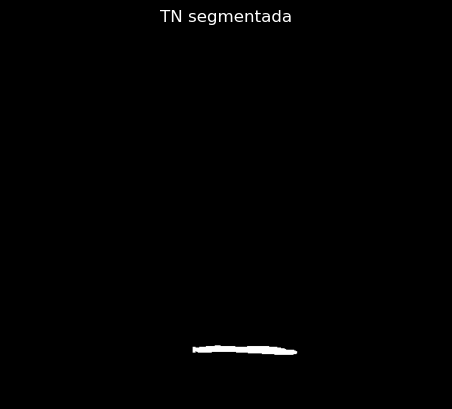

In [37]:
img_sitk = sitk.GetImageFromArray(sp_img)
img_seg = sitk.ConnectedThreshold(img_sitk, seedList=[(x, y)])
img_seg = My_Image(sitk.GetArrayFromImage(img_seg))

fig_seg, ax_seg = plt.subplots()
ax_seg.imshow(img_seg, vmin=0, vmax=1, cmap='gray')
ax_seg.set_title('TN segmentada')
plt.axis(False)
plt.show()

Para obtener el borde de este segmento, se aplicará un filtro pasa-altos laplaciano. La función de filtrado tambien se encuentra en My_Image, y lo que hace es implementar una convolución de la imagen con un kernel preespecificado.

In [38]:
def filter_w_kernel(self: np.ndarray,
                   kernel: np.ndarray, *,
                   pad_mode: str='zero',
                   output_dtype: np.number | None = None) -> Self:
        """
        kernel: kernel matrix to convolute with the image
        pad_mode: chosen padding method, either 'zero' or 'expand'
        output_dtype: specifies image depth for the output

        return: the filtered image after convoluting with the kernel
        """
        if output_dtype is None:
            output_dtype = self.dtype

        d = kernel.shape[0]
        N, M = self.shape
        pad_num = d//2
        dtype_data = np.iinfo(output_dtype)
        MIN_VAL, MAX_VAL = dtype_data.min, dtype_data.max

        if pad_mode == 'zero':
            padded_img = self.zero_pad(d)
        elif pad_mode =='expand':
            padded_img = self.expand_pad(d)
        else:
            raise ValueError(f"'{pad_mode}' is not a valid padding mode," +
                            "should  be either 'zero' or 'expand'")

        filtered_img = np.zeros_like(self, dtype=output_dtype)
        for i in range(pad_num, N):
            for j in range(pad_num, M):
                window = padded_img[i - pad_num : i + pad_num + 1,
                                    j - pad_num : j + pad_num + 1]
                new_value = np.sum(window*kernel)

                # map the output value to the valid range (MIN_VAL, MAX_VAL)
                if new_value < MIN_VAL:
                    new_value = MIN_VAL
                elif new_value > MAX_VAL:
                    new_value = MAX_VAL

                filtered_img[i, j] = new_value

        return My_Image(filtered_img)

Definimos el kernel, y filtramos.

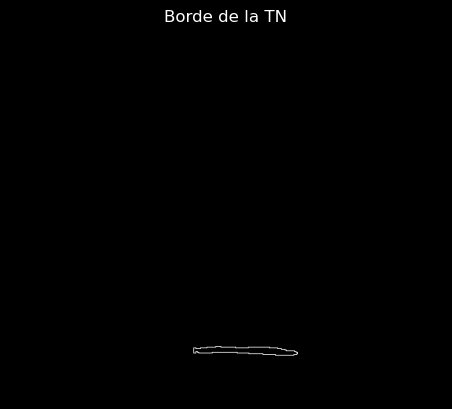

In [57]:
img_seg[img_seg > 0] = 255
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg1 = img_seg.filter_w_kernel(KL1)

plt.imshow(border_seg1, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.title('Borde de la TN')
plt.show()

Finalmente, se utiliza este borde para ajustar una elipse, y la medida de su diámetro menor nos da un estimado de la TN. La función de regresión lineal se encuentra en el módulo _my\_image\_processor_, y consiste en encontrar los coeficientes
$$ Ax^2 + Bxy + Cy^2 + Dx + Ey = F$$
que mejor ajusten a las coordenadas del borde extraido. Luego, la medida en píxeles de la TN se convierte a mm utilizando la escala de la imagen de ultrasonido, a partir de la cual se halla la resolución $c \frac{[px]}{[mm]}$

In [ ]:
 def plot_with_ellipse(self, ellipse_patch: Ellipse, c: float = 0.1719077568134172) -> None:
        """
        Plots the image alongside a fitted ellipse

        arg c: float indicating pixel resolution in [px/mm]
        """

        center = ellipse_patch.center
        R_min, R_max = ellipse_patch.height / 2, ellipse_patch.width / 2
        angle = np.pi*ellipse_patch.angle/180
        offset_point = np.array([ -R_min * np.sin(angle), R_min * np.cos(angle)])
        TN_topmark = np.floor(center + offset_point)
        TN_botmark = np.floor(center - offset_point)
        TN_meas = np.linalg.norm(TN_topmark - TN_botmark)
        #
        fig, ax = plt.subplots()# figsize=(10, 10))
        ax.imshow(self, vmin=0, vmax=255, cmap='gray')
        ax.add_patch(ellipse_patch)
        ax.plot(center[0], center[1], 'ro', markersize=1)
        ax.plot([TN_topmark[0], TN_botmark[0]], [TN_topmark[1], TN_botmark[1]],
                linestyle='--',
                color='y',
                marker='+',
                markersize=6,
                linewidth=0.5,
                label=f"TN={TN_meas / c:.2f} [mm]")

        plt.legend(loc='upper left', fontsize='big', prop={'weight': 'bold'})
        plt.axis('off')
        plt.show()

c:\Users\gonza\Documents\ITBA\2024 1C\TP PSIB\TP_PSIB\TP PIB\my_img_processor.py:356: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(A, b)[0].squeeze()


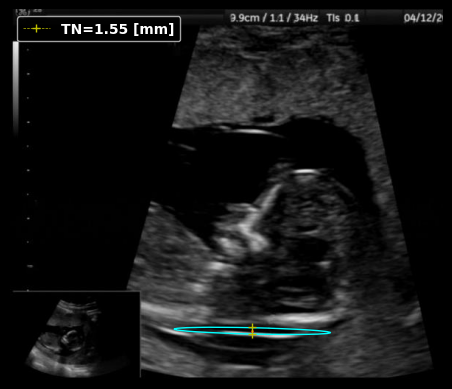

In [58]:
c = (500 - 23)/82
1/c
ellipse_patch = border_seg1.fit_ellipse()
raw_img.plot_with_ellipse(ellipse_patch, c)

#### 2) Etiquetado

Luego de que se seleccione el punto en el gráfico interactivo, y antes de aplicarle a la imagen la función de etiquetado, la imagen se binariza por Otsu del mismo modo que va a ocurrir luego en la segmetación por region growing.
Una vez hecha la binarización, se realiza el etiquetado de la imagen y además se va a poder visualizar su histograma.
binarizar_otsu() es una función que esta dentro de My_Image(), que va a convertir una imagen a color a escala de grises en casos que sea necesario y luego la binarización de otsu donde se determina un umbral automático que convierte a la imagen en binaria.


In [41]:
def binarizar_otsu(self):
        """
        Uses the cv2 module to apply otsu binarization
        """
        if len(self.shape) == 3:
            imagen_gris = cv2.cvtColor(self, cv2.COLOR_BGR2GRAY)
        else:
            imagen_gris = self
        _, imagen_binaria = cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return My_Image(imagen_binaria)
        

La función etiquetar_componentes() también se encuentra en My_Image, esta se encarga de identificar y etiquetar todas la regiones conectadas en una imagen binaria utilizando la conectividad en 8 direcciones.

In [ ]:
def etiquetar_componentes(self) -> Tuple[Self, int]:
        """
        Aplicamos el método de etiquetado de scipy
        """
        dtype_data = np.iinfo(self.dtype)
        MAX_VAL = dtype_data.max
        estructura = np.ones((3, 3), dtype=int) 
        imagen_etiquetada, num_features = label(self, structure=estructura)
        imagen_etiquetada_tipada = (imagen_etiquetada * (MAX_VAL // num_features)).astype(self.dtype)
        return My_Image(imagen_etiquetada_tipada), num_features

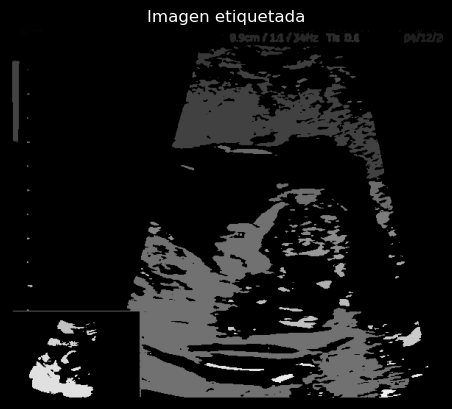

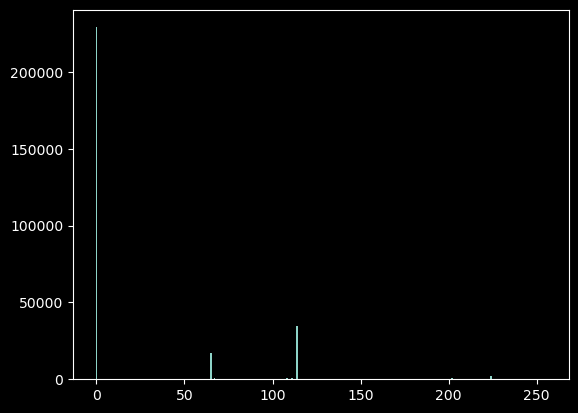

In [42]:
# Etiquetamos
imagen_binaria = raw_img.binarizar_otsu()
imagen_etiquetada, num_features = imagen_binaria.etiquetar_componentes()

plt.imshow(imagen_etiquetada, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title('Imagen etiquetada')
imagen_etiquetada.get_hist(plot=True);


Para extraer el área de la imagen por etiquetado, primero se invierten los valores de intensidad y luego utilizando la intensidad del punto que se seleccionó se van tomando todos los puntos de su alrededor con la misma característica hasta que encuentra otro de valor diferente, ese es el limite. Ambos método están implementados en el módulo propio.

In [ ]:
def invertir_imagen(self) -> Self:
        """
        Devuelve una version invertida en intensidad de la imagen
        """
        dtype_data = np.iinfo(self.dtype)
        MIN_VAL, MAX_VAL = dtype_data.min, dtype_data.max
        return  MAX_VAL - self


def extraer_area_por_intensidad(self, punto: np.ndarray | Tuple[int, int] | List[int]) -> Self:
        """
        Segmenta una seccion de una imagen binarizada de igual intensidad

        Args:
            punto (np.ndarray | Tuple[int, int] | List[int]): semilla para comenzar a buscar puntos

        Returns:
            Self: imagen binaria segmentada
        """
        intensidad_punto = self[punto[1], punto[0]]
        mascara = My_Image(np.zeros_like(self, dtype=self.dtype))
        MAX_VAL = np.iinfo(self.dtype).max
        puntos_a_revisar = [punto]
        direcciones = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        while puntos_a_revisar:
            x, y = puntos_a_revisar.pop()
            if x < 0 or y < 0 or x >= self.shape[1] or y >= self.shape[0]:
                continue
            if mascara[y, x] == 0 and self[y, x] == intensidad_punto:
                mascara[y, x] = MAX_VAL
                for dx, dy in direcciones:
                    puntos_a_revisar.append((x + dx, y + dy))

        return mascara

Las anteriores funciones, ambas, se encuentran en My_Image.

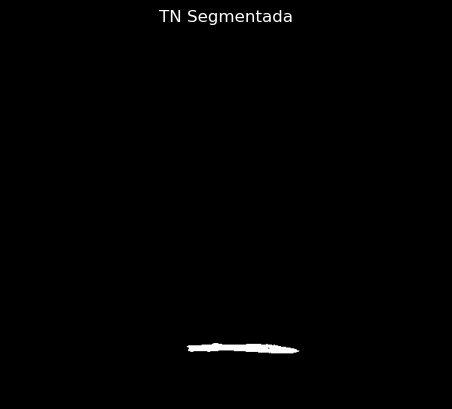

In [43]:
# Invertimos y extraemos la seccion
imagen_invertida = imagen_etiquetada.invertir_imagen()
#Definir el punto 
punto = (x, y)
#Extraer el area
area_extraida = imagen_invertida.extraer_area_por_intensidad(punto)

plt.imshow(area_extraida, vmin=0, vmax=255, cmap='gray')
plt.axis(False)
plt.title('TN Segmentada')
plt.show()

Como hay presencia de ruido sal pimienta, pasamos la imagen obtenida por el filtro de mediana que lo elimina y obtenemos al igual que en el anterior caso, el borde del área.

Text(0.5, 1.0, 'Aplicamos sal y pimienta')

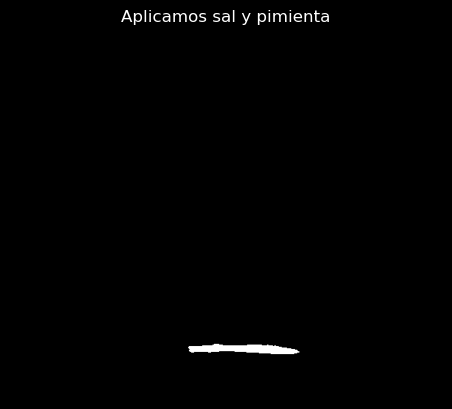

In [56]:
# Aplicamos sal y pimienta
area_extraida_limpia = area_extraida.median_filter(window_size=3)
plt.imshow(area_extraida_limpia, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.title('Aplicamos sal y pimienta')


Nuevamente, hallamos el borde y ajustamos la elipse.

In [45]:
# Hallamos el borde
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg2 = area_extraida_limpia.filter_w_kernel(KL1)

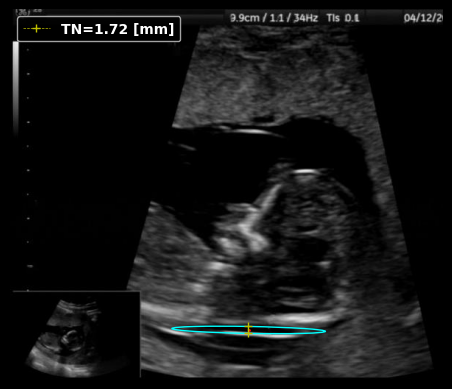

In [46]:
# Fitteamos la elipse
ellipse_patch = border_seg2.fit_ellipse()
plt.close()
raw_img.plot_with_ellipse(ellipse_patch, c)

#### 3) Region growing

Para este método de segmentación, se trabaja particularmente con dos puntos, el primero es el punto semilla y el segundo va a ser utilizado para calcular una distacia máxima que va a servir para limitar el área.
Antes de aplicar el region growing, la imagen se binariza utilizando otsu. 
La función de region growing se va a encontrar definidas en My_Image.

In [ ]:
def region_growing(self, 
                       seed: list | np.ndarray, 
                       thresh: float=10., 
                       max_dist: float=100.0) -> Self:
        """
        Realiza el algoritmo de crecimiento de regiones limitado a una distancia máxima desde la semilla.
        """
        #Inicializar la imagen de salida y una lista de píxeles por procesar
        height, width = self.shape
        segmented_img = np.zeros((height, width), np.uint8)
        segmented_img = My_Image(segmented_img)
        segmented_img[seed[1], seed[0]] = 255
        pixel_list = [seed]

        #Definir los movimientos posibles 
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        while pixel_list:
            x, y = pixel_list.pop(0)
            for dx, dy in moves:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height:
                    if segmented_img[ny, nx] == 0 and abs(int(self[ny, nx]) - int(self[y, x])) <= thresh:
                        dist = np.sqrt((nx - seed[0])**2 + (ny - seed[1])**2)
                        if max_dist is None or dist <= max_dist:
                            segmented_img[ny, nx] = 255
                            pixel_list.append((nx, ny))

        return segmented_img

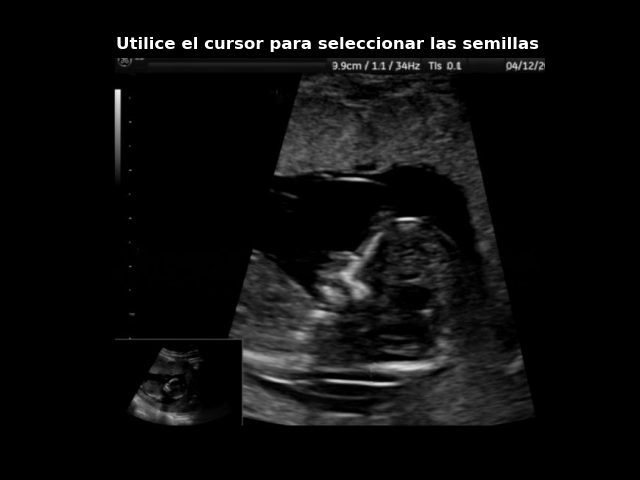

x=219, y=406
x=379, y=437
x=274, y=433


In [51]:
%matplotlib widget
x, y = 315, 432
x_y_vals = [(x, y)]
def interactive_plot(img):
   plt.ion()
   fig, ax = plt.subplots()
   fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)
   ax.set_title('Utilice el cursor para seleccionar las semillas', fontweight='bold')

   def onclick(event):
      global x
      global y
      global x_y_vals
      x = int(np.ceil(event.xdata))
      y = int(np.ceil(event.ydata))
      x_y_vals.append((x, y))
      print(f"{x=}, {y=}")
      ax.plot(x, y, marker='x', color='yellow')
      ax.figure.canvas.draw()
      fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)

   ax.imshow(img, vmin=0, vmax=255, cmap='gray')
   plt.axis(False)
   fig.canvas.mpl_connect('button_press_event', onclick)
   plt.show()

interactive_plot(raw_img)

In [52]:
plt.close()
%matplotlib inline

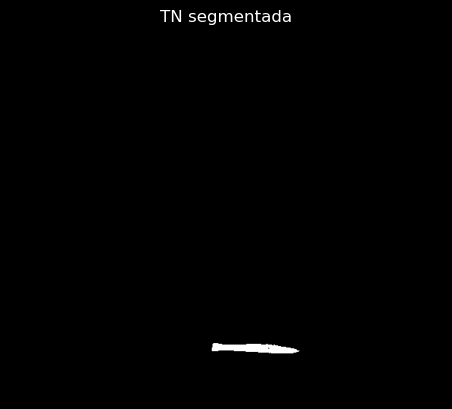

In [55]:
#Calcular la distancia
def calcular_distancia(punto1, punto2):
    return np.sqrt((punto1[0] - punto2[0])**2 + (punto1[1] - punto2[1])**2)


img = My_Image(img_path)
imagen_binaria = img.binarizar_otsu()

#Definir la semilla para el crecimiento 
seed_point = x_y_vals[-2]

#Definir el segundo punto para calcular la distancia máxima
second_point = x_y_vals[-1]  

max_distance = calcular_distancia(seed_point, second_point)
segmented_image = imagen_binaria.region_growing(seed_point, thresh=10, max_dist=max_distance)

plt.close()
plt.imshow(segmented_image, vmin=0, vmax=255, cmap='gray')
plt.title('TN segmentada')
plt.axis('off')
plt.show()

Al igual que antes, extraemos su correspondiente borde y ajustamos la elipse

In [59]:
# Hallamos el borde
segmented_image[segmented_image > 0] = 255
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg3 = segmented_image.filter_w_kernel(KL1)

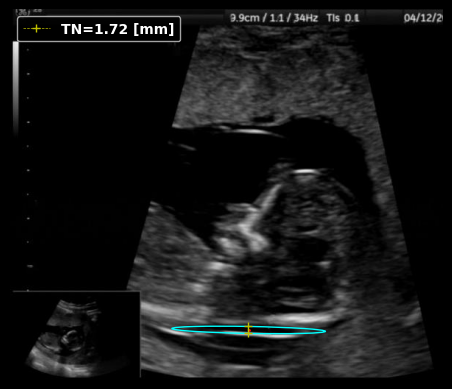

In [60]:
# Fitteamos la elipse nuevamente
ellipse_patch = border_seg2.fit_ellipse()
raw_img.plot_with_ellipse(ellipse_patch, c)

### Discusión
En la clínica, el método de medición de la TN es operador dependiente. El médico debe seleccionar manualmente los dos píxeles que considere que mejor representen una medida del ancho de la elipsoide, y este es el valor que se informa. Esto implica que existe un margen de variabilidad para este parámetro, dado que dos operadores distintos podrían obtener resultados significativamente diferentes. En cada uno de los métodos que se plantearon en este trabajo, la medición es determinística, y depende únicamente de que el ecografista halla seleccionado un punto (cualquiera) dentro del área de la translucencia nucal. Esto permite una replicabilidad de las mediciones, y una estandarización del método.

### Conclusión
ivo escribe esta parte

### Referencias
[1] C. Cui and F. Dong, “Dataset for Fetus Framework,” vol. 1, Sep. 2022, doi: 10.17632/n2rbrb9t4f.1.

[2] Y.-H. Deng, Y.-Y. Wang, and P. Chen, “Estimating Fetal Nuchal Translucency Parameters from its Ultrasound Image,” in 2008 2nd International Conference on Bioinformatics and Biomedical Engineering, May 2008, pp. 2643–2646. doi: 10.1109/ICBBE.2008.994.

[3] K. H. Nicolaides, G. Azar, D. Byrne, C. Mansur, and K. Marks, “Fetal nuchal translucency: ultrasound screening for chromosomal defects in first trimester of pregnancy,” BMJ (Clinical research ed.), vol. 304, no. 6831, pp. 867–869, Apr. 1992, doi: 10.1136/bmj.304.6831.867.

[4] D. Ramos, J. C. Santiago, M. J. Castillo, and F. Montoya, “Translucencia nucal,” Clínica e Investigación en Ginecología y Obstetricia, vol. 32, no. 2, pp. 54–60, Mar. 2005, doi: 10.1016/S0210-573X(05)73477-8.